# Testing
### Liegenschaften-Markt Stadt Zürich: Preisreihen (Medianpreise) und Verkaufsmengen nach Zonenart und Stadtquartier, seit 2008
Datum: 31.03.2022

### Importiere die notwendigen Packages

In [44]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [52]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import seaborn as sns
import plotly.express as px
import leafmap


import requests
import io

In [53]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [54]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [55]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [111]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [112]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 4 datenstand:  2 time.struct_time(tm_year=2022, tm_mon=4, tm_mday=5, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=95, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [113]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [147]:
package_name = "archiv_bau514od5141"
#package_name = "bau_hae_lima_preise_anzahl_hae_art_gebiet_bzo_jahr"

In [148]:
dataset_name = "BAU514OD5141.csv"

**Statische Pfade in DWH-Dropzones**

In [149]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [150]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [151]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [152]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [153]:
from IPython.display import Markdown as md

In [154]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_archiv_bau514od5141 

In [155]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/archiv_bau514od5141 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [156]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "integ"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

integ - web


In [157]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.integ.stadt-zuerich.ch/dataset/int_dwh_archiv_bau514od5141/download/BAU514OD5141.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [158]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['Jahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['Jahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


Typ                       object
PreisreiheSort             int64
PreisreiheLang            object
ArtSort                    int64
ArtLang                   object
Gebiet_s                   int64
Gebiet_n                  object
Jahr              datetime64[ns]
BZO                       object
ALLE                     float64
ZE                       float64
KE                       float64
QU                       float64
W2                       float64
W23                      float64
W34                      float64
W45                      float64
W56                      float64
dtype: object

Berechne weitere Attribute falls notwendig

In [159]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        Jahr_str = lambda x: x.Jahr.astype(str),
    )
    .sort_values('Jahr', ascending=False)
    )
data2betested.dtypes

Typ                       object
PreisreiheSort             int64
PreisreiheLang            object
ArtSort                    int64
ArtLang                   object
Gebiet_s                   int64
Gebiet_n                  object
Jahr              datetime64[ns]
BZO                       object
ALLE                     float64
ZE                       float64
KE                       float64
QU                       float64
W2                       float64
W23                      float64
W34                      float64
W45                      float64
W56                      float64
Jahr_str                  object
dtype: object

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [164]:
#data2betested.head(6)
data2betested.sort_values(['Jahr','Gebiet_s','PreisreiheSort'],ascending = [False, True, True])

,Typ,PreisreiheSort,PreisreiheLang,ArtSort,ArtLang,Gebiet_s,Gebiet_n,...,QU,W2,W23,W34,W45,W56,Jahr_str
0,Preis,41,Preis pro m2 Grundstücksfläche,31,Nur ganze Liegenschaften,0,Ganze Stadt,...,19847,6865,5908,7120,11209,NaN,2021-01-01
56,Preis,41,Preis pro m2 Grundstücksfläche,39,Alle Verkäufe,0,Ganze Stadt,...,30964,8922,10401,9954,15970,22009,2021-01-01
28,Preis,41,Preis pro m2 Grundstücksfläche,32,Nur Stockwerkeigentum,0,Ganze Stadt,...,39254,10262,12381,12281,22994,22009,2021-01-01
70,Menge,41,Preis pro m2 Grundstücksfläche,39,Alle Verkäufe,0,Ganze Stadt,...,104,115,161,266,69,20,2021-01-01
14,Menge,41,Preis pro m2 Grundstücksfläche,31,Nur ganze Liegenschaften,0,Ganze Stadt,...,47,45,54,77,33,0,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9141,Preis,42,"Preis pro m2 Grundstücksfläche, abzgl. Versich...",32,Nur Stockwerkeigentum,123,Hirzenbach,...,NaN,NaN,NaN,NaN,NaN,NaN,2008-01-01
9127,Menge,42,"Preis pro m2 Grundstücksfläche, abzgl. Versich...",31,Nur ganze Liegenschaften,123,Hirzenbach,...,0,0,1,2,0,0,2008-01-01
9169,Preis,42,"Preis pro m2 Grundstücksfläche, abzgl. Versich...",39,Alle Verkäufe,123,Hirzenbach,...,NaN,NaN,796,1956,NaN,NaN,2008-01-01
9197,Preis,49,Stockwerkeigentum pro m2 Wohnungsfläche,39,Alle Verkäufe,123,Hirzenbach,...,NaN,NaN,NaN,NaN,NaN,NaN,2008-01-01


In [161]:
data2betested.dtypes

Typ                       object
PreisreiheSort             int64
PreisreiheLang            object
ArtSort                    int64
ArtLang                   object
Gebiet_s                   int64
Gebiet_n                  object
Jahr              datetime64[ns]
BZO                       object
ALLE                     float64
ZE                       float64
KE                       float64
QU                       float64
W2                       float64
W23                      float64
W34                      float64
W45                      float64
W56                      float64
Jahr_str                  object
dtype: object

In [129]:
data2betested.shape

(9212, 19)

Beschreibe einzelne Attribute

In [130]:
data2betested.describe()

,PreisreiheSort,ArtSort,Gebiet_s,ALLE,ZE,KE,QU,W2,W23,W34,W45,W56
count,9212,9212,9212,9034,5355,5888,6362,4978,7012,7204,6310,5541
mean,43,35,63,6373,2437,5321,4788,454,1763,2372,2681,2548
std,3,4,36,12917,9226,15659,9793,1784,3084,4098,6422,6883
min,41,31,0,0,0,0,0,0,0,0,0,0
25%,41,31,31,15,0,0,0,0,0,0,0,0
50%,42,32,63,291,0,0,2,0,8,10,1,0
75%,42,39,92,8169,1,8,5254,0,2951,3706,1720,2
max,49,39,123,191429,135974,199353,99854,16907,23053,29240,95813,58997


Wie viele Nullwerte gibt es im Datensatz?

In [131]:
data2betested.isnull().sum()

Typ                  0
PreisreiheSort       0
PreisreiheLang       0
ArtSort              0
ArtLang              0
Gebiet_s             0
Gebiet_n             0
Jahr                 0
BZO                  0
ALLE               178
ZE                3857
KE                3324
QU                2850
W2                4234
W23               2200
W34               2008
W45               2902
W56               3671
Jahr_str             0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [132]:
data2betested = data2betested.set_index("Jahr")

In [133]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9212 entries, 2021-01-01 to 2008-01-01
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Typ             9212 non-null   object 
 1   PreisreiheSort  9212 non-null   int64  
 2   PreisreiheLang  9212 non-null   object 
 3   ArtSort         9212 non-null   int64  
 4   ArtLang         9212 non-null   object 
 5   Gebiet_s        9212 non-null   int64  
 6   Gebiet_n        9212 non-null   object 
 7   BZO             9212 non-null   object 
 8   ALLE            9034 non-null   float64
 9   ZE              5355 non-null   float64
 10  KE              5888 non-null   float64
 11  QU              6362 non-null   float64
 12  W2              4978 non-null   float64
 13  W23             7012 non-null   float64
 14  W34             7204 non-null   float64
 15  W45             6310 non-null   float64
 16  W56             5541 non-null   float64
 17  Jahr_str       

Int64Index([2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [134]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [135]:
data2betested.loc["2010"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,Typ,PreisreiheSort,PreisreiheLang,ArtSort,ArtLang,Gebiet_s,Gebiet_n,...,QU,W2,W23,W34,W45,W56,Jahr_str
Jahr,,,,,,,,,,,,,,,
2010-01-01,Menge,49,Stockwerkeigentum pro m2 Wohnungsfläche,39,Alle Verkäufe,52,Escher Wyss,...,0,0,0,0,0,0,2010-01-01
2010-01-01,Menge,42,"Preis pro m2 Grundstücksfläche, abzgl. Versich...",32,Nur Stockwerkeigentum,34,Sihlfeld,...,7,0,0,1,0,0,2010-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Preise pro m2 im Friesenberg

In [136]:
data2betested.dtypes

Typ                object
PreisreiheSort      int64
PreisreiheLang     object
ArtSort             int64
ArtLang            object
Gebiet_s            int64
Gebiet_n           object
BZO                object
ALLE              float64
ZE                float64
KE                float64
QU                float64
W2                float64
W23               float64
W34               float64
W45               float64
W56               float64
Jahr_str           object
dtype: object

In [138]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]

myAgg = data2betested.loc["2021"].query('Typ == "Preis" & Gebiet_n == "Ganze Stadt"')\
    .groupby(['Jahr','Typ','PreisreiheSort','PreisreiheLang']) \
    .agg(sum_ALLE=('ALLE', 'sum'),sum_ZE=('ZE', 'sum'),sum_W2=('W2', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAgg.reset_index().head(8)

,Jahr,Typ,PreisreiheSort,PreisreiheLang,sum_ALLE,sum_ZE,sum_W2
0,2021-01-01,Preis,41,Preis pro m2 Grundstücksfläche,47520,75790,26049
1,2021-01-01,Preis,42,"Preis pro m2 Grundstücksfläche, abzgl. Versich...",23090,66412,17091
2,2021-01-01,Preis,49,Stockwerkeigentum pro m2 Wohnungsfläche,14795,0,0


In [139]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]

myAgg = data2betested.loc["2009":"2021"].query('Typ == "Preis" & Gebiet_n == "Friesenberg" & PreisreiheLang =="Preis pro m2 Grundstücksfläche"')\
    .groupby(['Jahr','Typ','PreisreiheSort', 'ArtLang', 'Gebiet_s', 'Gebiet_n','BZO']) \
    .agg(sum_ALLE=('ALLE', 'sum'),sum_ZE=('ZE', 'sum'),sum_W2=('W2', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAgg.reset_index().head(8)

,Jahr,Typ,PreisreiheSort,ArtLang,Gebiet_s,Gebiet_n,BZO,sum_ALLE,sum_ZE,sum_W2
0,2009-01-01,Preis,41,Alle Verkäufe,33,Friesenberg,BZO99,5102,0,0
1,2009-01-01,Preis,41,Nur Stockwerkeigentum,33,Friesenberg,BZO99,5204,0,0
2,2009-01-01,Preis,41,Nur ganze Liegenschaften,33,Friesenberg,BZO99,4024,0,0
3,2010-01-01,Preis,41,Alle Verkäufe,33,Friesenberg,BZO99,4324,0,0
4,2010-01-01,Preis,41,Nur Stockwerkeigentum,33,Friesenberg,BZO99,10803,0,0
5,2010-01-01,Preis,41,Nur ganze Liegenschaften,33,Friesenberg,BZO99,3906,0,0
6,2011-01-01,Preis,41,Alle Verkäufe,33,Friesenberg,BZO99,6379,0,0
7,2011-01-01,Preis,41,Nur Stockwerkeigentum,33,Friesenberg,BZO99,6512,0,0


In [140]:
myAgg.reset_index().dtypes

Jahr              datetime64[ns]
Typ                       object
PreisreiheSort             int64
ArtLang                   object
Gebiet_s                   int64
Gebiet_n                  object
BZO                       object
sum_ALLE                 float64
sum_ZE                   float64
sum_W2                   float64
dtype: object

In [142]:
myTitle="Summe aller Preise von Handänderungen im Friesenberg"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['ArtLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_ALLE > 1'), title=myTitle).encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_ALLE', axis=alt.Axis(title='Summe alle Preise'))
    , color=alt.Color('ArtLang', legend=alt.Legend(title="Art der HAE", orient="right"))  
    ,tooltip=['Jahr', 'ArtLang','sum_ALLE', 'sum_ZE', 'sum_W2']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

In [143]:
myAggMenge = data2betested.loc["2008":"2021"].query('Typ == "Menge" & Gebiet_n == "Friesenberg" & PreisreiheLang =="Preis pro m2 Grundstücksfläche"')\
    .groupby(['Jahr','Typ','PreisreiheSort', 'ArtLang', 'Gebiet_s', 'Gebiet_n','BZO']) \
    .agg(sum_ALLE=('ALLE', 'sum'),sum_ZE=('ZE', 'sum'),sum_W2=('W2', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAggMenge.reset_index().head(3)

,Jahr,Typ,PreisreiheSort,ArtLang,Gebiet_s,Gebiet_n,BZO,sum_ALLE,sum_ZE,sum_W2
0,2008-01-01,Menge,41,Alle Verkäufe,33,Friesenberg,BZO99,1,0,0
1,2008-01-01,Menge,41,Nur Stockwerkeigentum,33,Friesenberg,BZO99,0,0,0
2,2008-01-01,Menge,41,Nur ganze Liegenschaften,33,Friesenberg,BZO99,1,0,0


In [144]:
myTitle="Anzahl Handänderungen im Friesenberg"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['ArtLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAggMenge.reset_index().query('sum_ALLE > 1'), title=myTitle).encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_ALLE', axis=alt.Axis(title='Anzahl HAE'))
    , color=alt.Color('ArtLang', legend=alt.Legend(title="Art der HAE", orient="right"))  
    ,tooltip=['Jahr', 'ArtLang','sum_ALLE', 'sum_ZE', 'sum_W2']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**

-------------------------------------------------------

#### Barcharts mit Seaborn

In [61]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2021"]\
    .groupby(['Jahr', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum')) \
    .sort_values('Jahr', ascending=True) 

myAggBar.reset_index().head(3)

,Jahr,KreisLang,ProjStatus,sum_ProjAnzGbd,sum_ProjAnzWhg
0,2021-01-01,Kreis 1,Fertigerstellt,0,0
1,2021-01-01,Kreis 9,Bewilligt,74,602
2,2021-01-01,Kreis 8,Im Bau,37,98


In [62]:
#help(sns.catplot)     

In [63]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

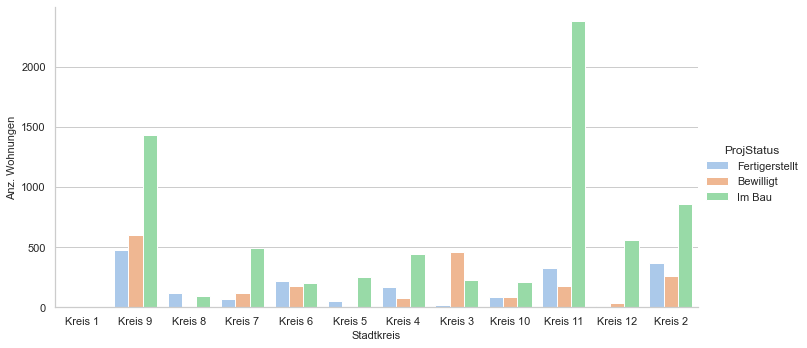

In [64]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="KreisLang"
            , y="sum_ProjAnzWhg"
            , hue="ProjStatus"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Stadtkreis', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Wohnungen', fontsize=11)


In [65]:
#data2betested.dtypes

In [66]:
myAggBar = data2betested.loc["2000":"2021"]\
    .groupby(['Jahr', 'QuarLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum')) \
    .sort_values('Jahr', ascending=True) 

C:\ProgramData\Anaconda3\envs\gogo_gis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  """Entry point for launching an IPython kernel.


In [67]:
#myAggBar.reset_index()

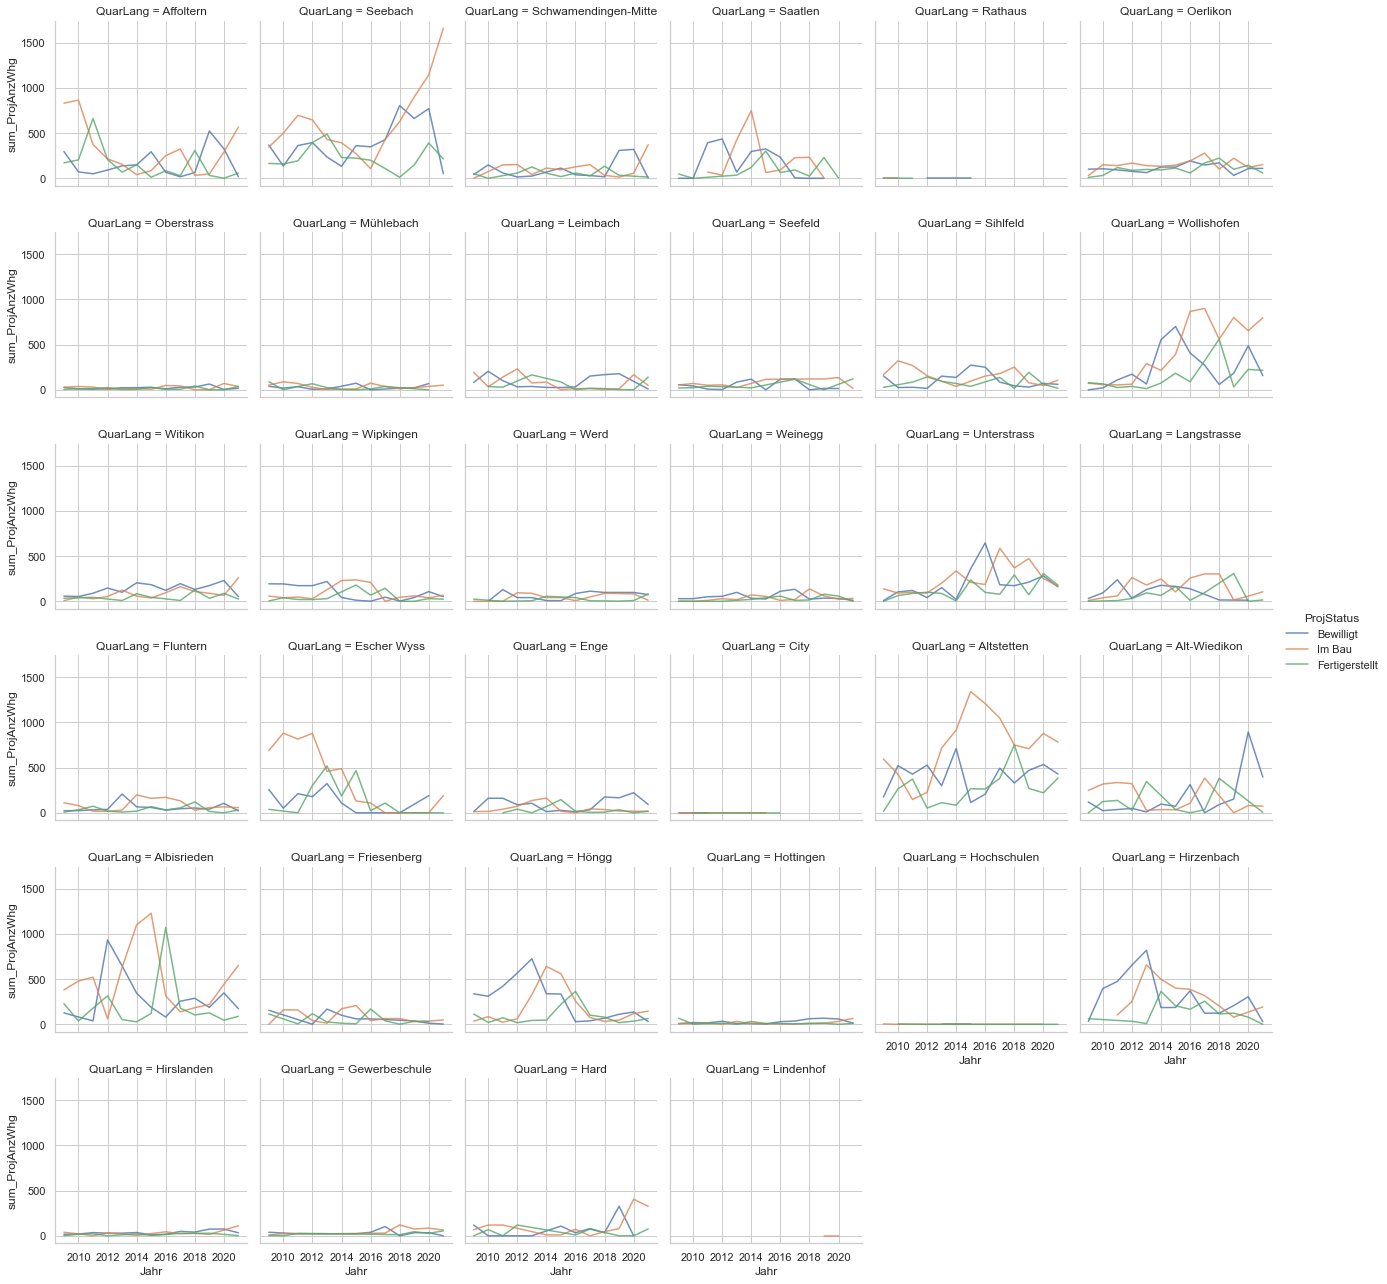

In [68]:
g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="ProjStatus", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_ProjAnzWhg", alpha=.8)
g.map(sns.lineplot, "Jahr","sum_ProjAnzWhg",alpha=.8)

g.add_legend()

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Anzahl Wohnungen in BAUPROJEKTEN nach Projektstatus, Kreis und Quartier 2021

In [54]:
data2betested.dtypes

QuarSort           int64
QuarLang          object
KreisSort          int64
KreisLang         object
ProjStatus        object
ProjAnzGbd         int64
ProjKosten         int64
ProjRauminhalt     int64
ProjAnzWhg         int64
Whg_1_3_Zi         int64
Whg_4plus_Zi       int64
Jahr_str          object
dtype: object

In [55]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjAnzGbd=('ProjAnzGbd', 'sum'),sum_ProjAnzWhg=('ProjAnzWhg', 'sum'))\
    .sort_values('sum_ProjAnzWhg', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,KreisLang,ProjStatus,sum_ProjAnzGbd,sum_ProjAnzWhg
0,2021-01-01,Seebach,Kreis 11,Im Bau,184,1659
1,2021-01-01,Wollishofen,Kreis 2,Im Bau,63,796
2,2021-01-01,Altstetten,Kreis 9,Im Bau,113,782


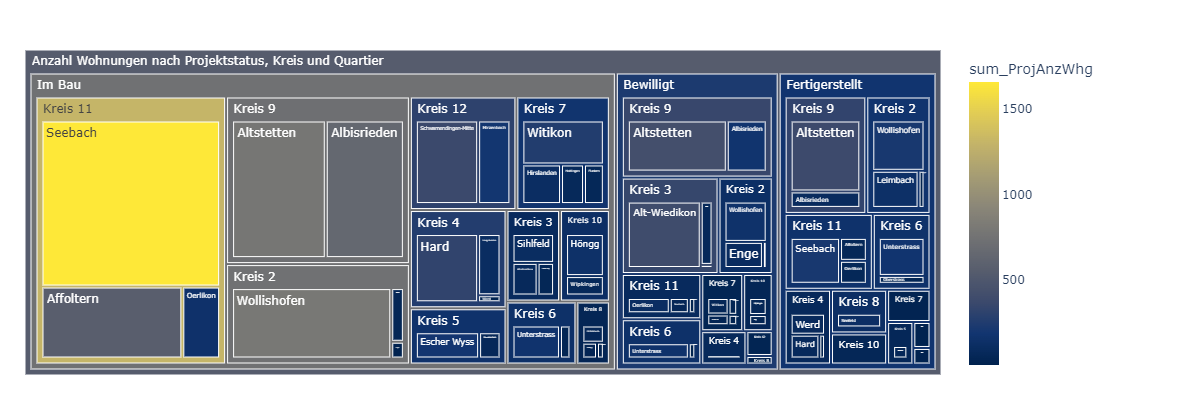

In [56]:
fig = px.treemap(myTreemapAgg.query('sum_ProjAnzWhg >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjAnzWhg'
                 , color='sum_ProjAnzWhg'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Anzahl Wohnungen nach Projektstatus, Kreis und Quartier

In [45]:
data2betested.dtypes

QuarSort           int64
QuarLang          object
KreisSort          int64
KreisLang         object
ProjStatus        object
ProjAnzGbd         int64
ProjKosten         int64
ProjRauminhalt     int64
ProjAnzWhg         int64
Whg_1_3_Zi         int64
Whg_4plus_Zi       int64
Jahr_str          object
dtype: object

In [46]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['Jahr', 'QuarLang', 'KreisLang', 'ProjStatus']) \
    .agg(sum_ProjKosten=('ProjKosten', 'sum'), sum_Whg_1_3_Zi=('Whg_1_3_Zi', 'sum'),sum_Whg_4plus_Zi=('Whg_4plus_Zi', 'sum'))\
    .sort_values('sum_Whg_1_3_Zi', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,KreisLang,ProjStatus,sum_ProjKosten,sum_Whg_1_3_Zi,sum_Whg_4plus_Zi
0,2021-01-01,Seebach,Kreis 11,Im Bau,867143,1098,561
1,2021-01-01,Wollishofen,Kreis 2,Im Bau,320688,611,185
2,2021-01-01,Altstetten,Kreis 9,Im Bau,593275,601,181


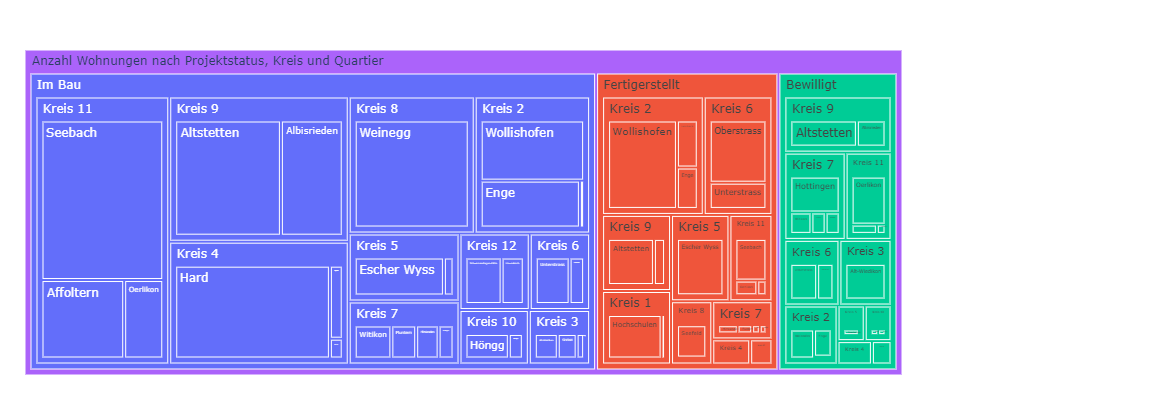

In [47]:
fig = px.treemap(myTreemapAgg.query('sum_ProjKosten >0').reset_index(), path=[px.Constant("Anzahl Wohnungen nach Projektstatus, Kreis und Quartier"),'ProjStatus', 'KreisLang', 'QuarLang']
                 , values='sum_ProjKosten'
                 , color='ProjStatus'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=400
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [48]:
#data2betested.dtypes

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [49]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [50]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [51]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [52]:
m = leafmap.Map()


#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

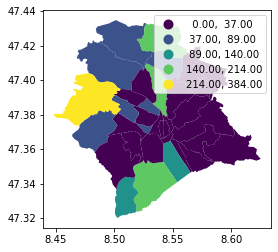

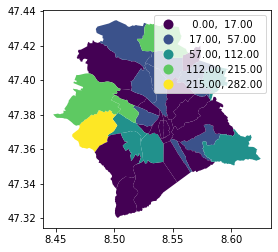

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

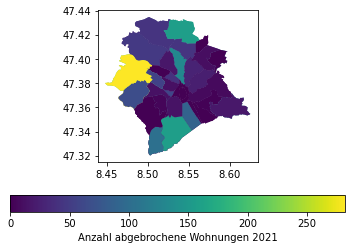

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=157&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**